In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
from shapely.geometry.polygon import LineString, Point
from deepracer.logs import PlottingUtils as pu
from deepracer.tracks import TrackIO, Track
tu = TrackIO()

Loaded 127 waypoints


/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/numpy/lib/twodim_base.py:148: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  m = asanyarray(m)
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/numpy/core/shape_base.py:123: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ary = asanyarray(ary)


<AxesSubplot:>

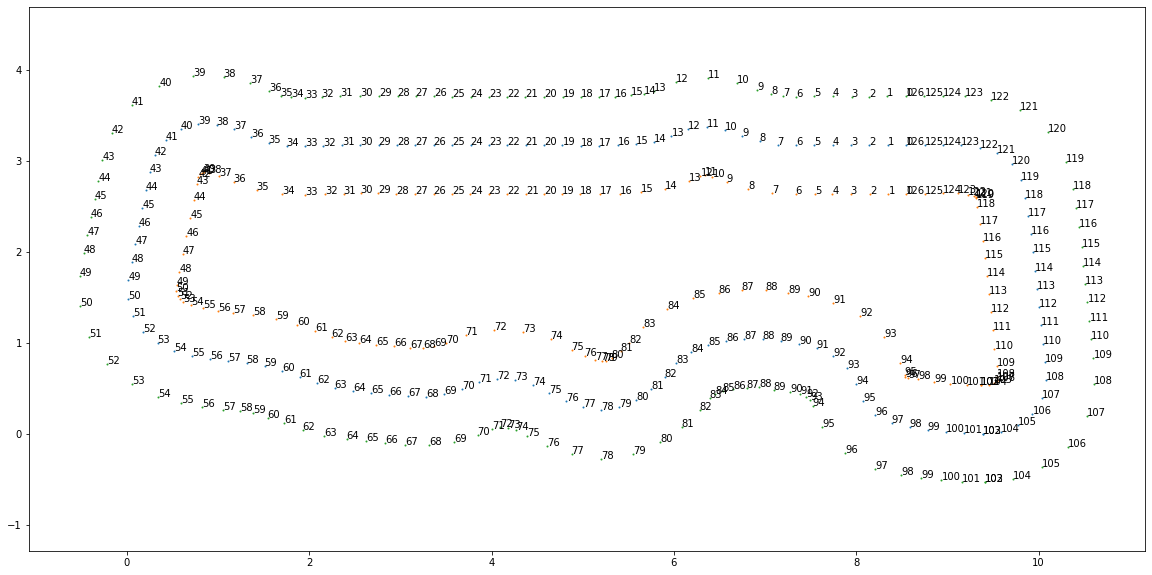

In [2]:
track: Track = tu.load_track("2022_summit_speedway")
pu.plot_trackpoints(track)

In [3]:
dist=[]
track_line = track.center_line
for i in np.arange(len(track_line[:-1])):
    j = ((i+2) % len(track_line))-1
    dist.append(np.linalg.norm(track_line[j] - track_line[i]))

print('Total distance of track: %.1f' % sum(dist))

Total distance of track: 25.2


In [5]:
# Without using premade Plotting utils class functions
# Easier to just use premade functions

# waypoints = np.load("tracks/reInvent2019_track.npy")
# center = [[line[0],line[1]] for line in waypoints]
# center = list(map(tuple,center))
# left = [[line[2],line[3]] for line in waypoints]
# left = list(map(tuple,left))
# right = [[line[4],line[5]] for line in waypoints]
# right = list(map(tuple,right))

# Visualise the Track and Create Functions

## Generate Directional Angle Array

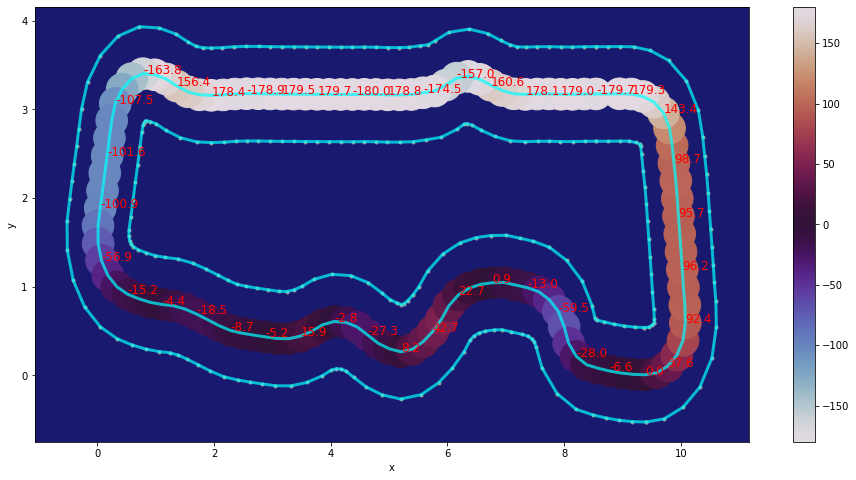

In [4]:
# Every point calculate the angular difference of track direction with 1 spacing between points
def track_dir(track_line,track,spacing=1,visualize=False):
    track_line = track_line[:-1]
    coord_diff = []
    track_angle = []
    for i in np.arange(len(track_line)-1):
        j = ((i+spacing+1) % len(track_line))-1
        coord_diff.append(list(track_line[j] - track_line[i]))
        track_angle.append(math.degrees(math.atan2(coord_diff[i][1],coord_diff[i][0])))
    
    if visualize == True:
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1)

        ax.set_facecolor('midnightblue')

        line = LineString(track.inner_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        line = LineString(track.outer_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        line = LineString(track.center_line)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        for i, p in enumerate(track_line[:-1]):
                if i % 3 == 0:
                    ax.annotate("{:.1f}".format(track_angle[i]), (p[0], p[1]), color='r',size=12)
                    
        pd.DataFrame(track_line[:-1],columns=list('xy')).plot.scatter('x','y',ax=ax, s=1000, c=track_angle,
                                cmap=plt.get_cmap('twilight'))

    #track_angle has values from -180 to 180 w.r.t x-axis
    #it's the same as params['heading'] / yaw variable
    return track_angle

track_angle = track_dir(track.center_line,track,visualize = True)

## Calculate the Direction Angular Difference

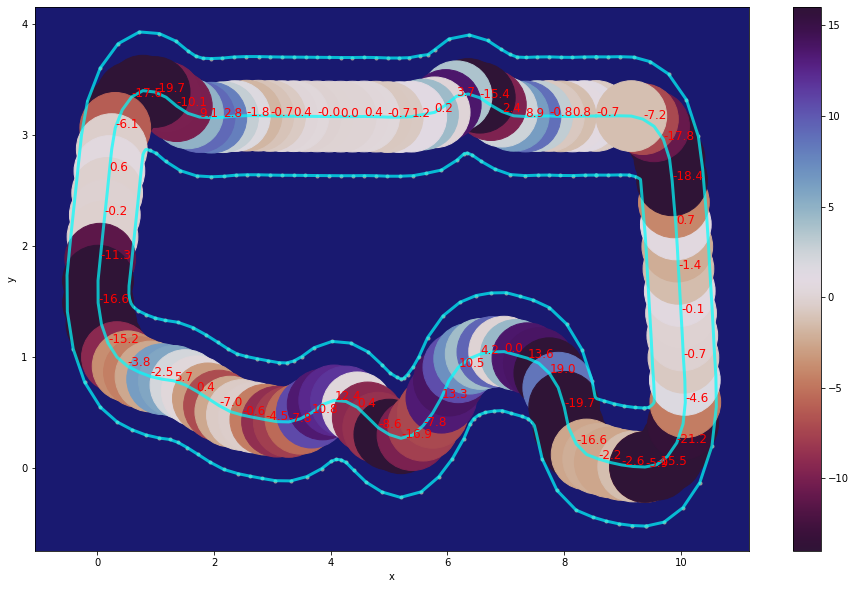

In [5]:
def track_angle_change(track_angle, track_line, track, visualize = True):
    track_line = track_line[:-2]
    def getAngleDifference(b1, b2):
        r = (b2 - b1) % 360.0
        # Python modulus has same sign as divisor, which is positive here,
        # so no need to consider negative case
        if r >= 180.0:
            r -= 360.0
        return r

    track_angle_diff = [getAngleDifference(t, s) for s, t in zip(track_angle, track_angle[1:])]
    #track_angle_diff.append(getAngleDifference(track_angle[0],track_angle[-1]))

    if visualize == True:

        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_facecolor('midnightblue')

        line = LineString(track.inner_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        line = LineString(track.outer_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        line = LineString(track.center_line)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        for i, p in enumerate(track_line[:-2]):
            if len(track_line[:-2]) >50:
                if i % 2 == 0:
                    ax.annotate("{:.1f}".format(track_angle_diff[i]), (p[0], p[1]), color='r',size=12)
            else:
                ax.annotate("{:.1f}".format(track_angle_diff[i]), (p[0], p[1]), color='r',size=12)
                
        if max(track_angle_diff)>15:
            vmax=15
        else:
            vmax = max(track_angle_diff)
        if min(track_angle_diff) <-15:
            vmin=-15
        else:
            vmin=min(track_angle_diff)
        if np.array_equal(track_line,track.center_line[:-2]):
            pd.DataFrame(track_line[:-1],columns=list('xy')).plot.scatter('x','y',ax=ax, s=5000, c=track_angle_diff,
                                    cmap=plt.get_cmap('twilight_shifted_r'),vmin=vmin+1,vmax=vmax+1)
        else:
            pd.DataFrame(track_line[:-1],columns=list('xy')).plot.scatter('x','y',ax=ax, s=200, c=track_angle_diff,
                                    cmap=plt.get_cmap('twilight_shifted_r'),vmin=vmin+1,vmax=vmax+1)
            
            
    return track_angle_diff
        
tac_track = track_angle_change(track_angle,track.center_line, track,visualize = True)

<AxesSubplot:>

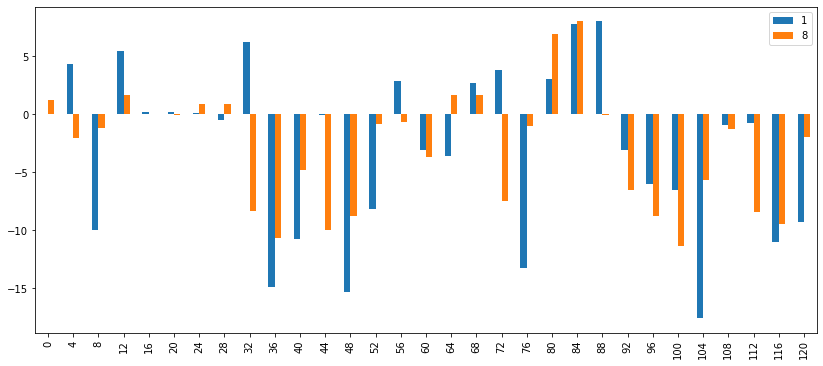

In [6]:
#Angle difference of next point
tac1 = track_angle_change(track_dir(track_line,track,spacing=1,visualize = False), track_line, track, visualize = False)
#Angle difference 8 points down the track
tac8 = track_angle_change(track_dir(track_line,track,spacing=8,visualize = False), track_line, track, visualize = False)
df = pd.DataFrame({'1':tac1,'8':tac8})
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
df.groupby(df.index // 4).mean().set_index(np.array(df.index)[::4]).plot.bar(ax=ax)

### Track Zones: Center, Left, Right

In [7]:
def mid_point(xy1,xy2):
    return [(xy1[0]+xy2[0])/2,(xy1[1]+xy2[1])/2]

left_mid = []
for coord1,coord2 in zip(track.outer_border,track.center_line):
    left_mid.append(mid_point(coord1,coord2))
left_mid = np.array(left_mid)

right_mid = []
for coord1,coord2 in zip(track.inner_border,track.center_line):
    right_mid.append(mid_point(coord1,coord2))
right_mid = np.array(right_mid)

## Create Racing Line Direcly Using Inputs

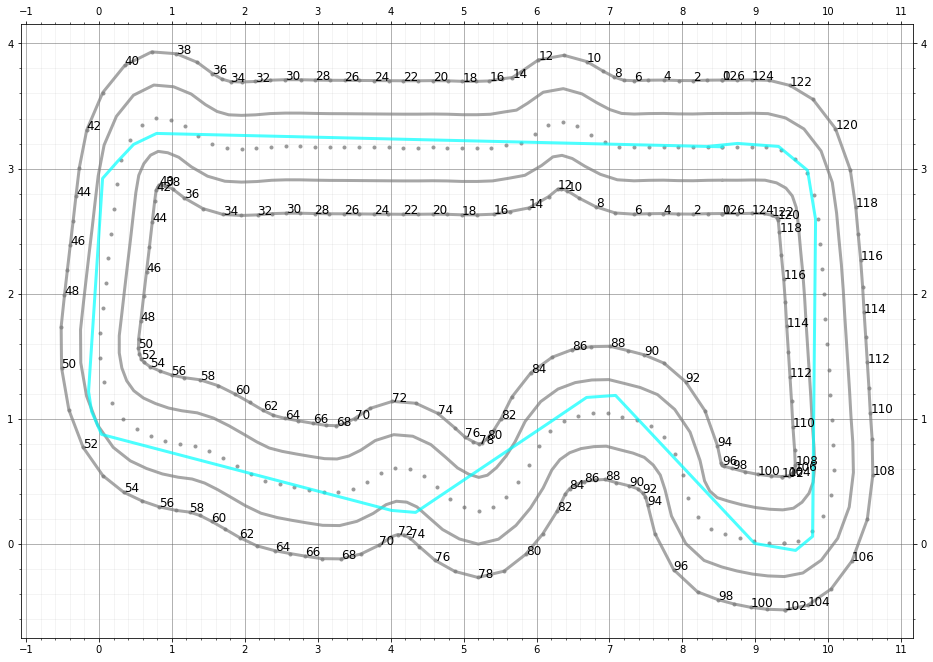

In [8]:
# Left click to add point
# Right click to remove last point
# Center mouse button to finish making racingline

import matplotlib
matplotlib.use('TkAgg') # Enable popout window
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
pu._plot_coords(ax, LineString(track.center_line))
# for i, p in enumerate(track.center_line):
#         if i % 2 == 0:
#             ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.inner_border),'grey')
pu._plot_coords(ax, LineString(track.inner_border))
for i, p in enumerate(track.inner_border):
        if i % 2 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.outer_border),'grey')
pu._plot_coords(ax, LineString(track.outer_border))
for i, p in enumerate(track.outer_border):
        if i % 2 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(left_mid),'grey')
pu._plot_line(ax, LineString(right_mid),'grey')
            

ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.grid(True,'major', color='#666666', ls='-', lw=0.5)
ax.xaxis.grid(True,'minor', color='#999999', ls='-', lw=0.5, alpha=0.2)
ax.yaxis.grid(True,'major', color='#666666', ls='-', lw=0.5)
ax.yaxis.grid(True,'minor', color='#999999', ls='-', lw=0.5, alpha=0.2)
ax.tick_params(which='both',top=True,right=True,labeltop=True, labelright=True)

xy = plt.ginput(n=1000, timeout=0, show_clicks=True,mouse_add=1, mouse_pop=3, mouse_stop=2)
xy[0]=tuple(track.center_line[0])
xy = np.asarray(xy)
pu._plot_line(ax,LineString(xy))

#matplotlib.use('agg')

def xy_interp(xy):
    import shapely
    from shapely.geometry import LineString, Point
    def intersect(A,B,C,D):
        line1 = LineString([A, B])
        line2 = LineString([C, D])
        int_pt = line1.intersection(line2)
        return  int_pt

    racingline = []
    pt_counter = 0

    for iline in range(0,len(xy)-1):
        A = xy[iline]
        B = xy[iline+1]
        #Iterate over track points
        while pt_counter<=len(track.center_line)-1:
            C = track.outer_border[pt_counter]
            D = track.inner_border[pt_counter]
            int_pt = intersect(A,B,C,D)
            #break if no itersection
            if not int_pt:
                break
            else:
                racingline.append([int_pt.x,int_pt.y])
                pt_counter += 1
            
    return racingline
racingline = np.array(xy_interp(xy))

TypeError: ginput() got an unexpected keyword argument 'key_release_event'

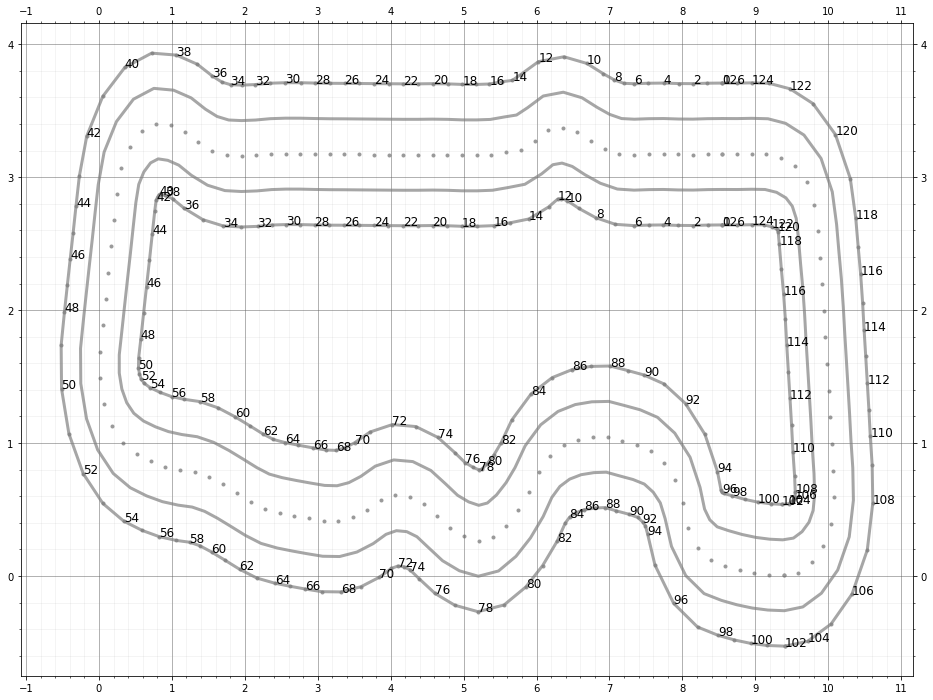

: 

In [22]:
# Left click to add point
# Right click to remove last point
# Press enter to finish making racing line

import matplotlib
matplotlib.use('TkAgg') # Enable popout window
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
pu._plot_coords(ax, LineString(track.center_line))
# for i, p in enumerate(track.center_line):
#         if i % 2 == 0:
#             ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.inner_border),'grey')
pu._plot_coords(ax, LineString(track.inner_border))
for i, p in enumerate(track.inner_border):
        if i % 2 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.outer_border),'grey')
pu._plot_coords(ax, LineString(track.outer_border))
for i, p in enumerate(track.outer_border):
        if i % 2 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(left_mid),'grey')
pu._plot_line(ax, LineString(right_mid),'grey')
            

ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.grid(True,'major', color='#666666', ls='-', lw=0.5)
ax.xaxis.grid(True,'minor', color='#999999', ls='-', lw=0.5, alpha=0.2)
ax.yaxis.grid(True,'major', color='#666666', ls='-', lw=0.5)
ax.yaxis.grid(True,'minor', color='#999999', ls='-', lw=0.5, alpha=0.2)
ax.tick_params(which='both',top=True,right=True,labeltop=True, labelright=True)

xy = plt.ginput(n=1000, timeout=0, show_clicks=True,mouse_add=1, mouse_pop=3, key_release_event=lambda event: event.key == 'enter')
xy[0]=tuple(track.center_line[0])
xy = np.asarray(xy)
pu._plot_line(ax,LineString(xy))

#matplotlib.use('agg')

def xy_interp(xy):
    import shapely
    from shapely.geometry import LineString, Point
    def intersect(A,B,C,D):
        line1 = LineString([A, B])
        line2 = LineString([C, D])
        int_pt = line1.intersection(line2)
        return  int_pt

    racingline = []
    pt_counter = 0

    for iline in range(0,len(xy)-1):
        A = xy[iline]
        B = xy[iline+1]
        #Iterate over track points
        while pt_counter<=len(track.center_line)-1:
            C = track.outer_border[pt_counter]
            D = track.inner_border[pt_counter]
            int_pt = intersect(A,B,C,D)
            #break if no itersection
            if not int_pt:
                break
            else:
                racingline.append([int_pt.x,int_pt.y])
                pt_counter += 1
            
    return racingline
racingline = np.array(xy_interp(xy))

In [9]:
#Save racing line as CSV
import time
df = pd.DataFrame(racingline, columns=['x racing', 'y racing'])
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
name = ('track_analysis_2022_summit_speedway '+timestamp+'.csv')
df.to_csv(name)

## https://mickqg.github.io/DeepracerBlog/part2.html#:~:text=Waypoints%20Reward%20Function&text=The%20following%20reward%20function%20gives,rewards%20and%20penalties%20are%20given.

In [10]:
#Read in racing line from CSV
df1 = pd.read_csv('track_analysis_2022_summit_speedway May-10-2023_1952.csv',index_col=0)
racingline = df1.values

In [11]:
dist_racing=[]
line = racingline
for i in np.arange(len(line[:-1])):
    j = ((i+2) % len(line))-1
    dist_racing.append(np.linalg.norm(line[j] - line[i]))
    
print('Total distance of central line: %.1f' % sum(dist))
print('Total distance of racing line: %.1f' % sum(dist_racing))

Total distance of central line: 25.2
Total distance of racing line: 25.1


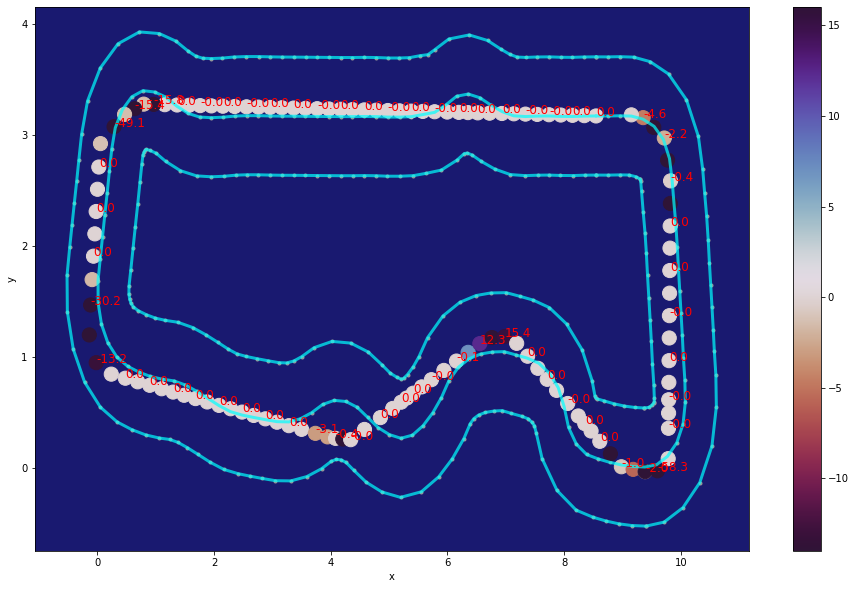

In [12]:
matplotlib.use('Agg')# Disable popout window
tac_racing = track_angle_change(track_dir(racingline,track,visualize = False), racingline, track, visualize = True)

In [13]:
print(len(tac_racing))
print(len(tac_track))

124
124


## Racing line turning angles

<AxesSubplot:>

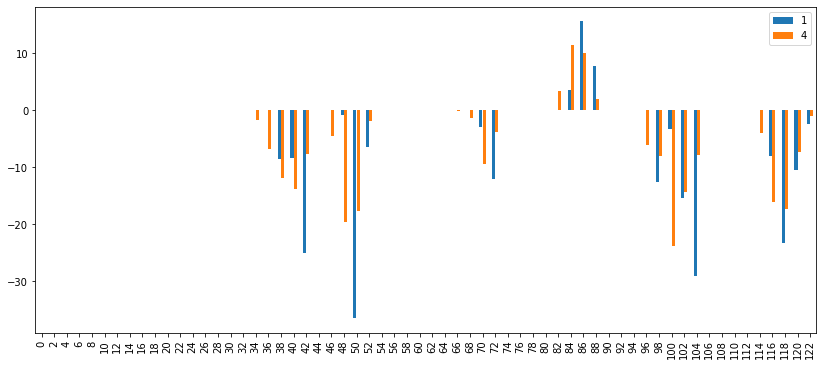

In [14]:
#Angle difference of next point
tac1 = track_angle_change(track_dir(line,track,spacing=1,visualize = False), line, track, visualize = False)
#Angle difference N points down the track
N=4
tacN = track_angle_change(track_dir(line,track,spacing=N,visualize = False), line, track, visualize = False)
df = pd.DataFrame({'1':tac1,'N':tacN})
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
df = df.groupby(df.index // 2).mean().set_index(np.array(df.index)[::2])
df = df.rename(columns={'N': N})
df.plot.bar(ax=ax)

<AxesSubplot:>

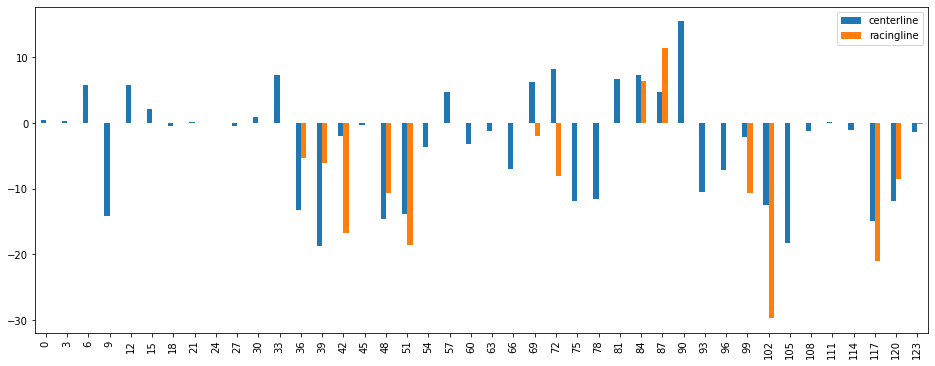

In [15]:
#Angle difference centerline vs racingline
df = pd.DataFrame({'centerline':tac_track,'racingline':tac_racing})
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(111)
df.groupby(df.index // 3).mean().set_index(np.array(df.index)[::3]).plot.bar(ax=ax)

## Classify Racing Line in 4 Track Regions

In [16]:
from shapely.geometry import Point, LineString
pts_left=np.zeros(len(track.center_line))
pts_center_left=np.zeros(len(track.center_line))
pts_center_right=np.zeros(len(track.center_line))
pts_right=np.zeros(len(track.center_line))

line_data = zip(racingline,track.outer_border,left_mid,track.center_line,right_mid,track.inner_border)
for i, (pt_rl,pt_L,pt_CL,pt_C,pt_CR,pt_R) in enumerate(line_data):
    line_L = LineString([tuple(pt_L),tuple(pt_CL)])
    line_CL = LineString([tuple(pt_CL),tuple(pt_C)])
    line_CR = LineString([tuple(pt_CR),tuple(pt_C)])
    line_R = LineString([tuple(pt_R),tuple(pt_CR)])
    if line_L.distance(Point(pt_rl)) < 1e-10:
        pts_left[i] = 1
    elif line_CL.distance(Point(pt_rl)) < 1e-10:
        pts_center_left[i] = 1
    elif line_CR.distance(Point(pt_rl)) < 1e-10:
        pts_center_right[i] = 1
    elif line_R.distance(Point(pt_rl)) < 1e-10:
        pts_right[i] = 1       
        
df_rl = pd.DataFrame(data={'racing line':racingline.tolist(),
                           'point number':np.arange(1,len(track.center_line)+1),
                            'left':pts_left.tolist(),
                            'center left':pts_center_left.tolist(),
                            'center right':pts_center_right.tolist(),
                            'right':pts_right.tolist()})

## Print Track Regions

In [17]:
left = df_rl[df_rl['left']==1]['point number']
print('left:',','.join(str(i) for i in list(left)))
print('\n')


center_left = df_rl[df_rl['center left']==1]['point number']
print('center left:', ','.join(str(i) for i in list(center_left)))
print('\n')

center_right = df_rl[df_rl['center right']==1]['point number']
print('center right:', ','.join(str(i) for i in list(center_right)))
print('\n')

right = df_rl[df_rl['right']==1]['point number']
print('right:', ','.join(str(i) for i in list(right)))
print('\n')


# center = df_rl[(df_rl['center right']==1) | (df_rl['center left']==1)]['point number']
# print('center:', ','.join(str(i) for i in list(center)))
# print('\n')

left: 53,72,73,74,75


center left: 1,2,3,4,5,6,7,8,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,60,61,62,68,69,70,71,76,92,93,94,101,102,103,104,105,106,121,123,124,125,126,127


center right: 9,10,11,12,13,14,38,39,40,41,42,63,64,65,66,67,77,78,83,84,85,86,87,88,89,90,91,95,96,97,98,99,100,107,111,112,113,114,115,116,117,118,119,120,122


right: 79,80,81,82,108,109,110




## Print racing line coordinates

In [18]:
%pprint
(racingline).tolist()

Pretty printing has been turned OFF


[[8.548611640930176, 3.173937439918518], [8.346921149080831, 3.176714699466032], [8.145276293340844, 3.179491330608512], [7.943830204859434, 3.1822652247440977], [7.74214643907861, 3.185042391674266], [7.540249376096464, 3.187822495687305], [7.338968058952142, 3.190594120936713], [7.139451657718586, 3.1933414434561382], [6.935314812646937, 3.1961523890628256], [6.722845216722324, 3.1990780758833965], [6.5211839935877824, 3.2018549324033962], [6.352641629110508, 3.2041757452816486], [6.195705115332824, 3.2063367466617643], [5.997768058521581, 3.209062321753556], [5.781902910214801, 3.212034765018549], [5.5798201922173405, 3.2148174254840964], [5.378967676458436, 3.2175831461778124], [5.179715773901936, 3.220326826574748], [4.979228854500288, 3.223087513040205], [4.777807560700389, 3.2258610657553044], [4.575391857423128, 3.2286483113975697], [4.373505332208461, 3.2314282703065187], [4.17218880896492, 3.23420038034068], [3.970696448011231, 3.2369749116439586], [3.769081154490234, 3.23975